In [1]:
import fastai
import torch
from fastai.vision import *
from shutil import copyfile


plt.rcParams.update({'font.size': 18})


In [2]:
dic = {
      'ATYPICAL_LYMPHOCYTE':[],
      'VARIANT_LYMPHOCYTE':[],
      'BLAST':[]
     }

## Se crean los directorios de células de CanRuti

In [3]:
def print_dirs_recursively(root_dir):
    root_dir = os.path.abspath(root_dir)

    for item in os.listdir(root_dir):
        item_full_path = os.path.join(root_dir, item)
        if os.path.isdir(item_full_path):
            print_dirs_recursively(item_full_path)
        else: 
            if '/SLPC/' in item_full_path:
                dic['ATYPICAL_LYMPHOCYTE'].append(item_full_path)
            if '/REACTIUS/' in item_full_path:
                dic['VARIANT_LYMPHOCYTE'].append(item_full_path)
            if '/LA/' in item_full_path:
                dic['BLAST'].append(item_full_path)

print_dirs_recursively('/shared/can_ruti')

In [4]:
#for item in dic.values():
#    for path in item:
#
#        if '/SLPC/' in path:
#            filename = os.path.basename(path)
#            copyfile(path, os.path.join("/shared/Classification_CanRuti/ATYPICAL_LYMPHOCYTE", filename))
#      
#        if '/REACTIUS/' in path:
#            filename = os.path.basename(path)
#            copyfile(path, os.path.join("/shared/Classification_CanRuti/VARIANT_LYMPHOCYTE", filename))
#            
#        if '/LA/' in path:
#            filename = os.path.basename(path)
#            copyfile(path, os.path.join("/shared/Classification_CanRuti/BLAST", filename))            
#                    
#
#

#### Descripción del Conjunto de datos de validación de Can Ruti

In [5]:
folder_1 = os.listdir("/shared/Datasets_Classification/Classification_CanRuti/ATYPICAL_LYMPHOCYTE")
folder_2 = os.listdir("/shared/Datasets_Classification/Classification_CanRuti/VARIANT_LYMPHOCYTE")
folder_3 = os.listdir("/shared/Datasets_Classification/Classification_CanRuti/BLAST")
dic_Classif = {
      'ATYPICAL_LYMPHOCYTE':len(folder_1),
      'VARIANT_LYMPHOCYTE':len(folder_2),
      'BLAST':len(folder_3)
     }

pd.DataFrame(dic_Classif, index=['N'])

,ATYPICAL_LYMPHOCYTE,VARIANT_LYMPHOCYTE,BLAST
N,47,57,80


In [6]:
folder_classes = "/shared/Datasets_Classification/Classification_CanRuti"
tfms = get_transforms(flip_vert=True, max_warp=None, max_zoom=1.01, max_rotate=120, max_lighting=0.1)





#### Creación de DataBunch

In [7]:
data = (ImageList.from_folder(folder_classes) #Where to find the data? -> in path and its subfolders
        .split_by_rand_pct(0.5,seed=4)           #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .transform(tfms, size=224)       #Data augmentation? -> use tfms with a size of 64
        .databunch(num_workers=0)
        .normalize(imagenet_stats))   

In [8]:
data.batch_size = 20

#### Descripción de conjuntos `train` y `valid` (validation set será el `test`)

In [9]:
pd.DataFrame.from_dict({'Number of classes':[data.c],
'train_size':[len(data.train_ds)],
'valid_size':[len(data.valid_ds)]},
orient = 'index', columns=['N'])

,N
Number of classes,3
train_size,92
valid_size,92


#### Descripción del reparto de clases en cada set

`Train set`

In [10]:
train_ds = data.train_ds.to_df()
pd.DataFrame(train_ds['y'].value_counts()).rename(columns={'y':'N'})

,N
BLAST,43
VARIANT_LYMPHOCYTE,27
ATYPICAL_LYMPHOCYTE,22


`Validation set`

In [11]:
valid_ds = data.valid_ds.to_df()
pd.DataFrame(valid_ds['y'].value_counts()).rename(columns={'y':'N'})

,N
BLAST,37
VARIANT_LYMPHOCYTE,30
ATYPICAL_LYMPHOCYTE,25


In [12]:
gc.collect()

7

data.show_batch()

# Test Canruti Resnet 34 (Santi) Preentrenada en Clinic NoSind

Se crea un learner con datos auxilares del clinic pero se sustituye con el Databunch de CanRuti anterior para validar en CanRuti. Nótese que se incorporan los pesos del clínic con el método `.load()`

In [13]:
data.classes

['ATYPICAL_LYMPHOCYTE', 'BLAST', 'VARIANT_LYMPHOCYTE']

In [14]:
folder_model = "/shared/modelos"
learn = None
learn = load_learner(folder_model, 'export_Resnet34_3types_BAL_resampling_NoLGL_NoSIND.pkl')
learn.data.classes = data.classes
learn.data = data

/opt/conda/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:434: SourceChangeWarning: source code of class 'fastai.layers.AdaptiveConcatPool2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/opt/conda/envs/fastai/lib/python3.6/site-packages/torch/serialization.py:434: SourceChangeWarning: source code of class 'fastai.layers.Flatten' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [15]:


results = learn.validate(data.valid_dl)
results
valid_CanRuti = dict(zip(['valid_loss', 'accuracy'],
                         [results[0], results[1].item()]))

pd.DataFrame(valid_CanRuti, index = ['metrics'])

,valid_loss,accuracy
metrics,3.549365,0.347826


In [16]:
plt.rcParams.update({'font.size': 18})

from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import precision_score, recall_score

def multiclass_roc_auc_score(y_test, y_pred, average="micro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

val_preds,val_targets = learn.get_preds() 

y_test = pd.Series(np.array(val_preds.max(1)[1])).map(dict(zip([0,1,2],learn.data.classes)))
y_true = pd.Series(np.array(val_targets)).map(dict(zip([0,1,2],learn.data.classes)))


precision = precision_score(y_test, y_true, average='micro')
recall = recall_score(y_test, y_true, average='micro')

pd.DataFrame({#'multiclass_roc_auc_score': multiclass_roc_auc_score(y_test, y_true),
             'precision':precision,
             'recall':recall,
             }, index = ['metrics'])

,precision,recall
metrics,0.347826,0.347826


In [17]:
learn.data.classes

['ATYPICAL_LYMPHOCYTE', 'BLAST', 'VARIANT_LYMPHOCYTE']

In [18]:
learn.data = data

In [19]:
learn.data.batch_size = 20

In [20]:
gc.collect()

0

In [21]:
learn.validate(data.valid_dl)

[3.5493653, tensor(0.3478)]

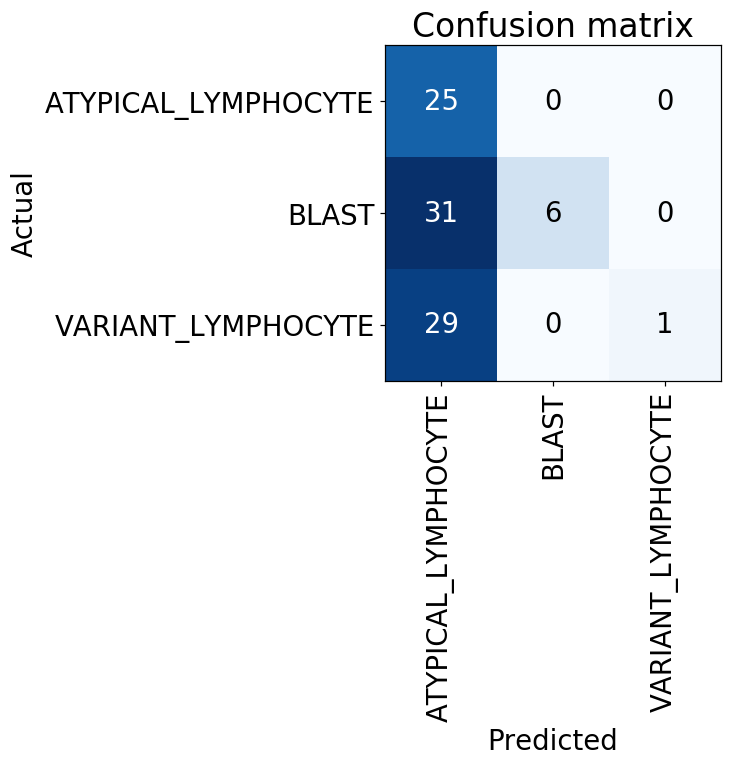

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
interp.plot_confusion_matrix(figsize=(7,7), dpi=110)

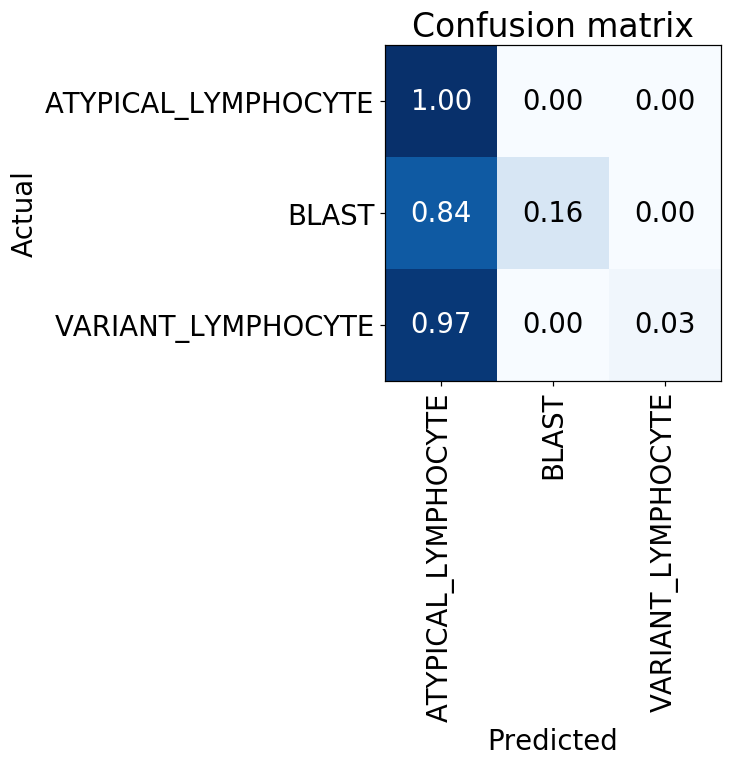

In [23]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=110, normalize=True)

In [24]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr = 3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.654650,1.382603,0.684783,00:01
1,0.386961,1.750118,0.663043,00:01
2,0.278145,1.087310,0.728261,00:01


In [25]:
learn.fit_one_cycle(3, max_lr = 3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.260450,0.356993,0.902174,00:01
1,0.187327,0.117800,0.967391,00:01
2,0.137629,0.088563,0.956522,00:01


In [26]:
learn.fit_one_cycle(3, max_lr = 3e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.061946,0.072514,0.967391,00:01
1,0.057952,0.033712,0.978261,00:01
2,0.068826,0.024310,0.989130,00:01


In [32]:
learn.export('export_stage-2-NoSIND_3_Classes')


In [33]:
plt.rcParams.update({'font.size': 18})

from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import precision_score, recall_score

def multiclass_roc_auc_score(y_test, y_pred, average="micro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

val_preds,val_targets = learn.get_preds() 

y_test = pd.Series(np.array(val_preds.max(1)[1])).map(dict(zip([0,1,2],learn.data.classes)))
y_true = pd.Series(np.array(val_targets)).map(dict(zip([0,1,2],learn.data.classes)))


precision = precision_score(y_test, y_true, average='micro')
recall = recall_score(y_test, y_true, average='micro')

pd.DataFrame({'multiclass_roc_auc_score': multiclass_roc_auc_score(y_test, y_true),
             'precision':precision,
             'recall':recall,
             }, index = ['metrics'])

,multiclass_roc_auc_score,precision,recall
metrics,0.991848,0.98913,0.98913


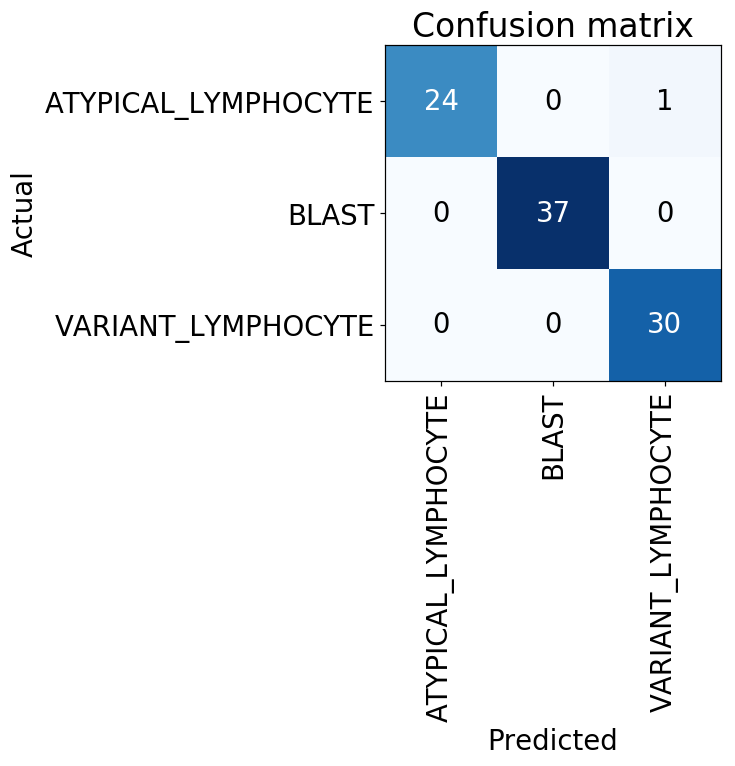

In [29]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
interp.plot_confusion_matrix(figsize=(7,7), dpi=110)

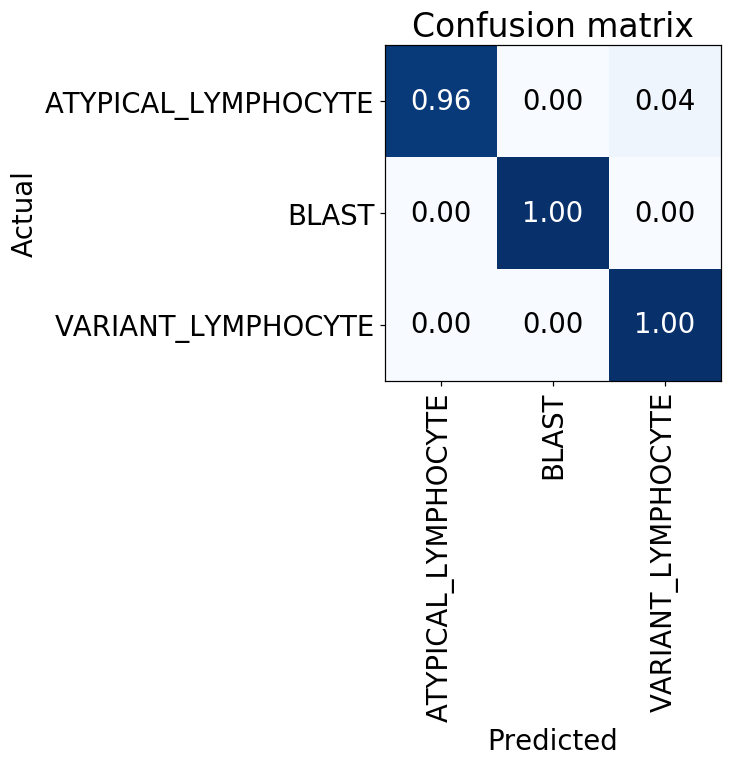

In [30]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=110, normalize=True)

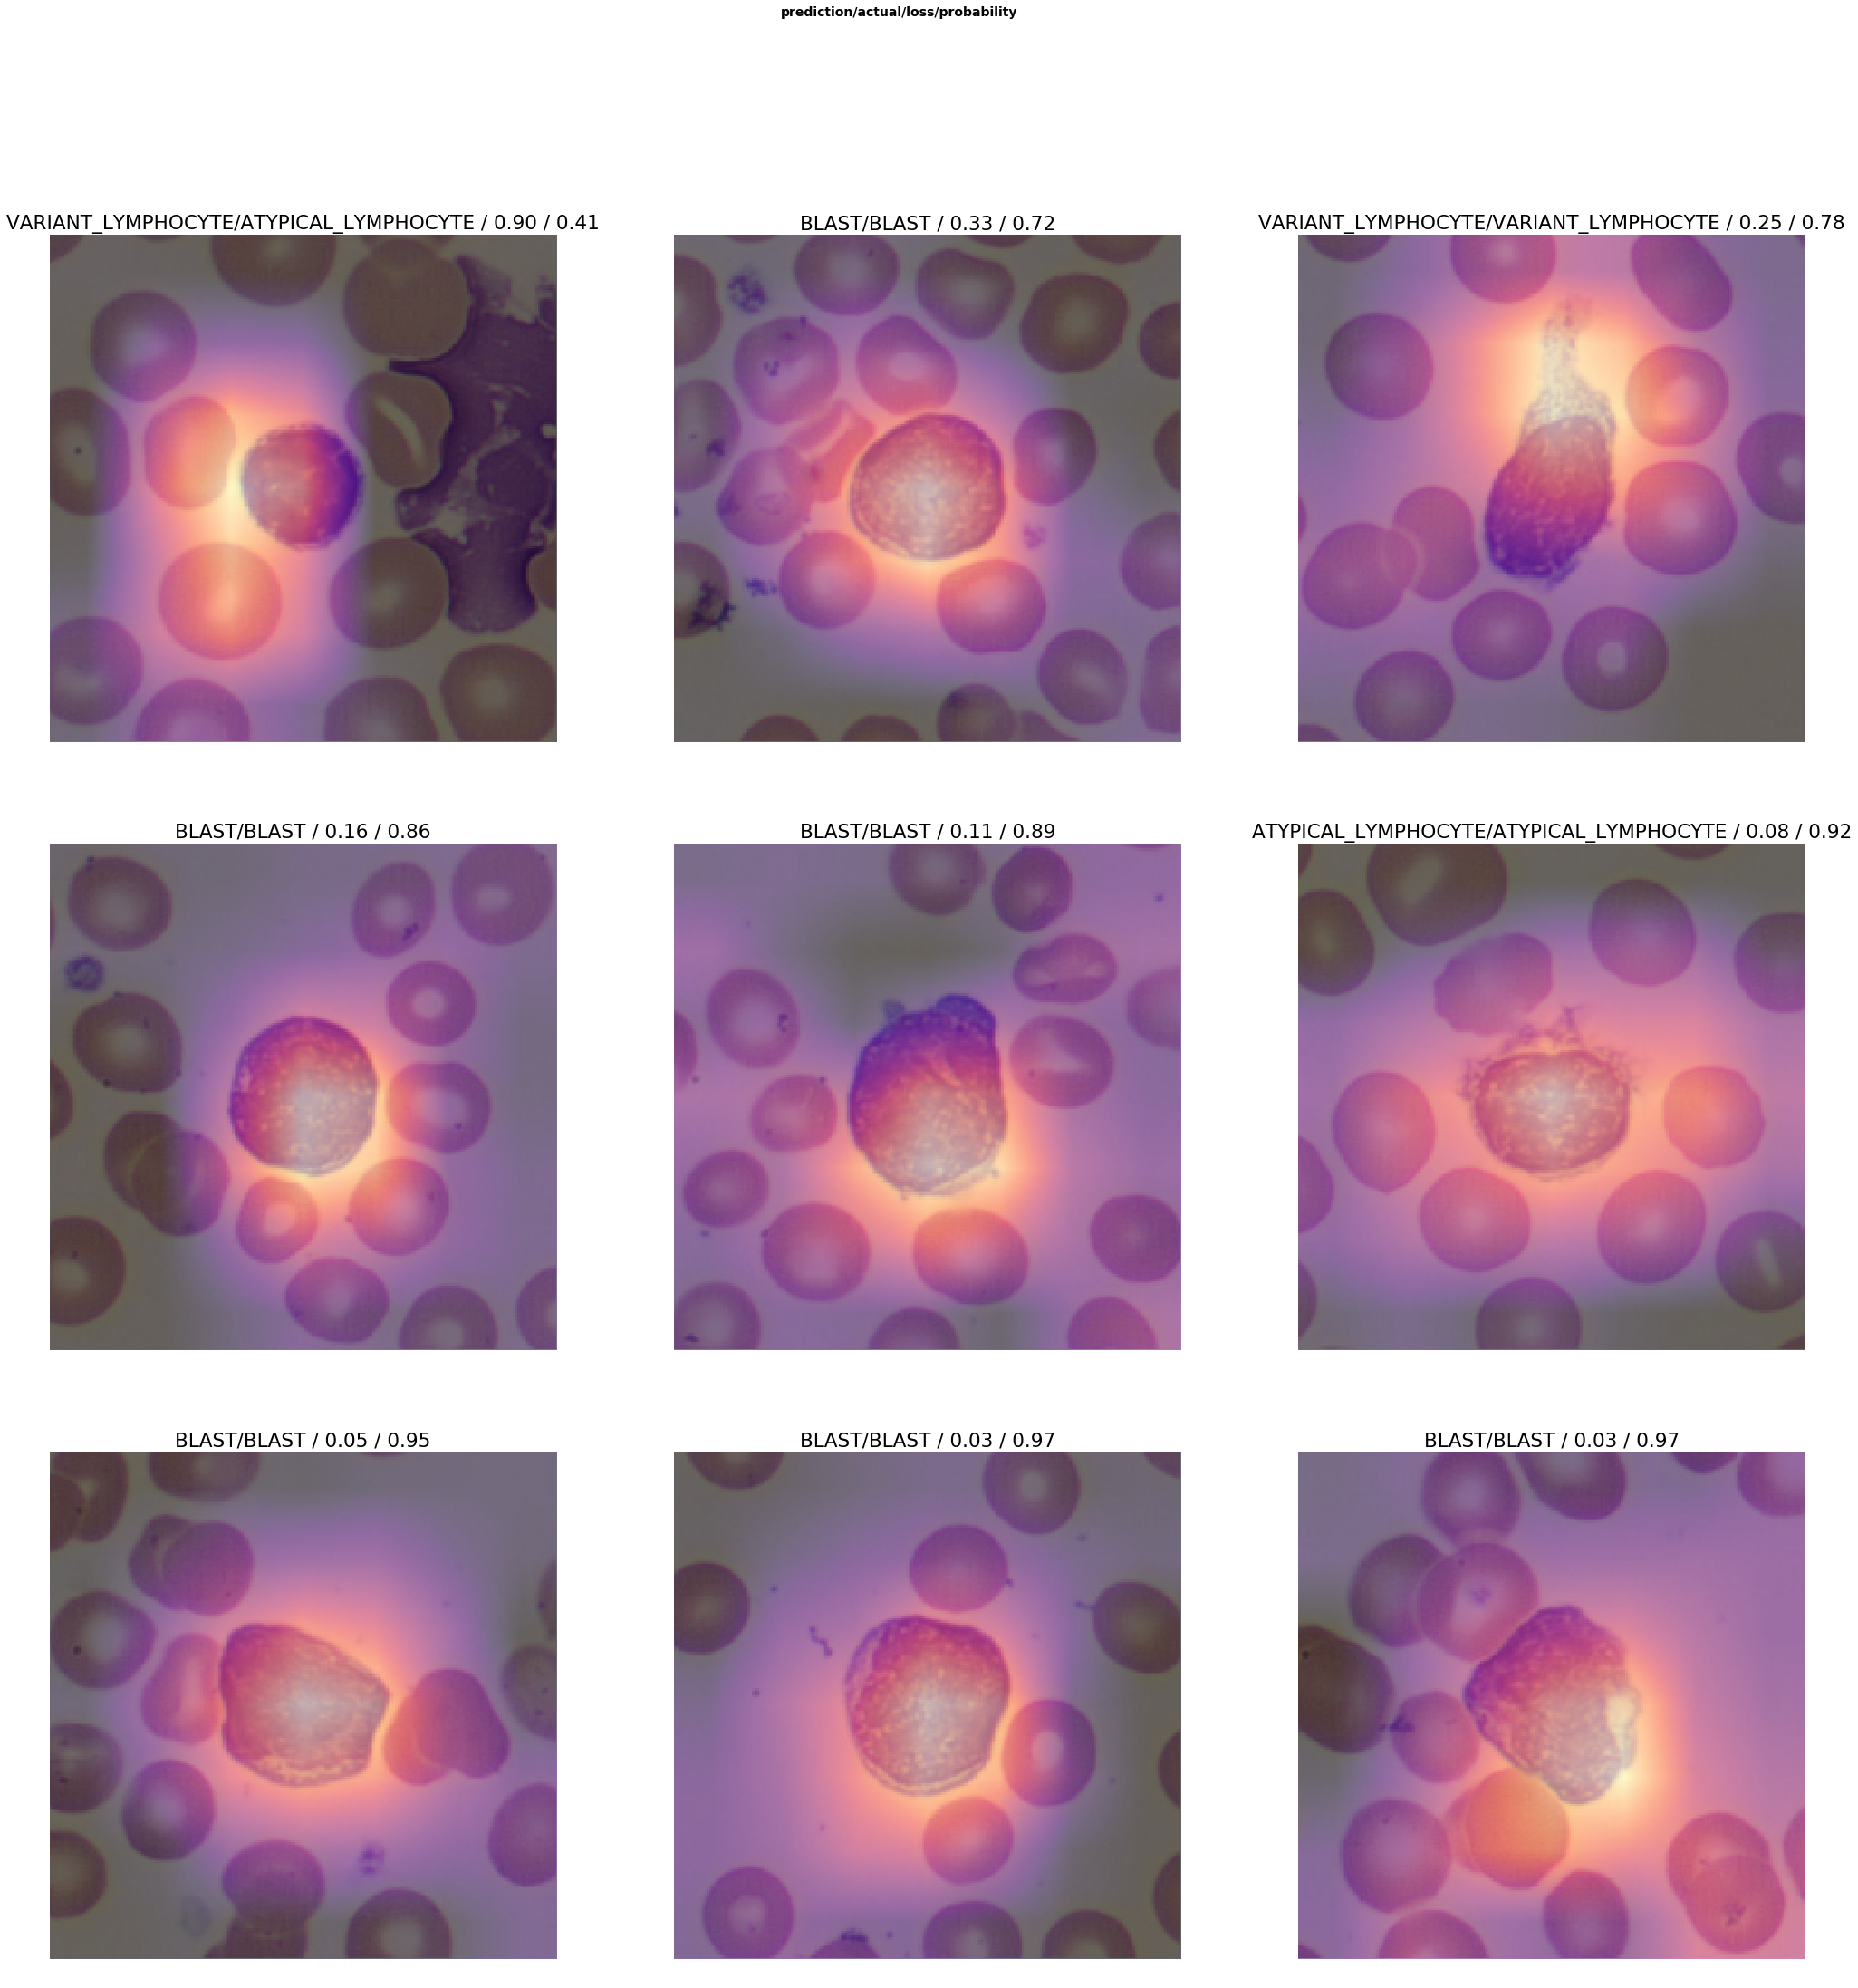

In [31]:
interp.plot_top_losses(9, largest=True, figsize=(35,35), heatmap=True)